I utilize publically available census data to perform exploratory data analysis. The purpose is to gain insights into communal well-being in the Indiana population.

Information regarding the PUMS survey and dataset can be found __[here](https://www.census.gov/programs-surveys/acs/microdata/documentation.html)__.


In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
pd.set_option("display.precision", 4)
import geopandas as gpd
import matplotlib.pyplot as plt
from functions import get_PUMA_dfs, moe_st_error, recode
%matplotlib inline

In [2]:
# Geopandas stuff
geo_data= gpd.read_file("Geo\cb_2018_18_puma10_500k.shp")
# geo_data = gpd.read_file("Geo\County\cb_2018_us_county_500k.shp")
geo_data = geo_data.sort_values(by='PUMACE10')


The Census Bureau uses a modified mean squared error function to calculate the standard errors, margins of errors, and confidence intervals. Information on how PUMS calculate the confidence intervals can be found __[here](https://www2.census.gov/programs-surveys/acs/tech_docs/pums/accuracy/2014_2018AccuracyPUMS.pdf)__.

Below is the function PUMS uses to calculate their standard error.
$$ SE(X) = \sqrt{4/80 * \sum_{r=1}^{80}(X_{r} - X)^{2}} $$
Where:
- $X_{r}$ is one of the replicate weights, r is index
- $X$ is the primary weight

The PUMS survey uses a 90% confidence interval.
$$ LB, UB = X \pm 1.645 * SE(X)$$
Where:
- 1.645 is the z - score for a 90% confidence level
- $1.645 * SE(X)$ is the margin of error (MOE)

The Census Bureau provides 80 replicate weights for error metrics.

The PUMS data dictionary can be found here: __[here](https://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMS_Data_Dictionary_2014-2018.pdf)__.

There are a large amount of features and most of the labels are non-intuitive. I'll identify variables as they become relevant. 

In [3]:
df = pd.read_csv(r'data\Pums_5_2018.csv'
                 ,na_values='',low_memory=False)

Dropping columns with over 90% missing values. After reviewing the columns fitting this threshold, I decided they would not be of much use for my purposes.

In [4]:
data = df.dropna(axis=1,thresh=(.1*len(df))).copy()

In [5]:
# For geopandas
data = data.rename({'PUMA':'PUMACE10'},axis=1)

Data shape for reference

In [6]:
data.shape

(333546, 263)

Checking that columns have appropriate datatypes, for computational efficiency

In [7]:
data.dtypes.value_counts()

int64      197
float64     62
object       4
dtype: int64

In [8]:
# Creating a column differentiating those below the poverty threshold
data['pov_bool'] = data['POVPIP'] < 100

In [9]:
bin_list = [0, 4, 9, 14, 19, 24, 34, 44, 54, 64, 74, 84, 99]
ages = ['Age 0-4', 'Age 5-9', 'Age 10-14', 'Age 15-19',
        'Age 20-24', 'Age 25-34', 'Age 35-44', 'Age 45-54', 'Age 55-64',
        'Age 65-74', 'Age 75-84', 'Age 85 and over']

In [10]:
# Creating a column grouping people by age using above lists
data['AgeRange'] = pd.cut(data['AGEP'],bin_list,
                         labels=ages,include_lowest=True)

In [11]:
# Coding race values and dropping values.
race_codes = {1:'White', 2:'African American', 3:'American Indian', 4:'Alaska Native',
             5: 'American Indian', 6:'Asian', 7:'Native Hawaiin/Pacific Islander'}
race_lst = list(race_codes.values())
data['RAC1P'] = data['RAC1P'].replace(8,np.NaN).replace(9,np.NaN).map(race_codes)

In [12]:
# Changing the gender column to Male/Female
data['SEX'] = data['SEX'].replace([1],'Male').replace([2],'Female')

The analysis I used to compare my numbers to had the bin sizes below. There is a focus on the older population.

The primary and replicate weights are labeled as follows:
- Primary (1):
    - Person Level:"PWGTP"
- Replicate (80):
    - Person Level:"PWGTP1" - "PWGTP80"

In [13]:
p = 'PWGTP'
w = list(data.filter(regex=r'PWGTP\d+?').columns)

The calculations originally covered 3 areas; this document only contains metrics for the entirity of Indiana. The areas were determined by PUMA codes. PUMA codes represent "Public Use Microdata Areas" and serve to segment populations into subsets of atleast 100,000 people.

Relevant areas:
- Indiana

In [14]:
Idata = data.dropna(axis=0,subset=['AgeRange']).copy()

# Indiana Weighted Sample Size by Age and Gender

In [15]:
# Grouping by age group and sex
age_dist = pd.DataFrame(Idata.groupby(['AgeRange','SEX'])
                        .sum()).reset_index()

In [16]:
# Two separate dataframes for male/female
m = age_dist[age_dist['SEX'] == 'Male']
f = age_dist[age_dist['SEX'] == 'Female']

In [17]:
# Moe, Standard Error, and Confidence Interval calculations
mout = moe_st_error(m[p],m[w],'Male')
mout.index = ages
fout = moe_st_error(f[p],f[w], 'Female')
fout.index = ages

In [18]:
mout.style.set_caption('Total Indiana Male Counts')

,Male,Male SE,Male MOE,Male LB,Male UB
Age 0-4,214126,2663.6126,219.0821,213906.9179,214345.0821
Age 5-9,224200,9094.9046,748.0559,223451.9441,224948.0559
Age 10-14,226833,9196.9562,756.4496,226076.5504,227589.4496
Age 15-19,234822,5144.7002,423.1516,234398.8484,235245.1516
Age 20-24,243034,5324.3626,437.9288,242596.0712,243471.9288
Age 25-34,430688,5743.5080,472.4035,430215.5965,431160.4035
Age 35-44,410168,4572.4072,376.0805,409791.9195,410544.0805
Age 45-54,429537,4106.6457,337.7716,429199.2284,429874.7716
Age 55-64,418696,3786.2604,311.4199,418384.5801,419007.4199
Age 65-74,270370,2848.6097,234.2981,270135.7019,270604.2981


In [19]:
fout.style.set_caption('Total Indiana Male Counts')

,Female,Female SE,Female MOE,Female LB,Female UB
Age 0-4,203368,2785.4558,229.1037,203138.8963,203597.1037
Age 5-9,213331,8902.2977,732.2140,212598.7860,214063.2140
Age 10-14,218903,8967.5318,737.5795,218165.4205,219640.5795
Age 15-19,225526,5400.4566,444.1876,225081.8124,225970.1876
Age 20-24,231152,4977.3359,409.3859,230742.6141,231561.3859
Age 25-34,428087,4435.0038,364.7791,427722.2209,428451.7791
Age 35-44,411496,4116.6234,338.5923,411157.4077,411834.5923
Age 45-54,435974,4142.2220,340.6978,435633.3022,436314.6978
Age 55-64,441663,2762.3240,227.2012,441435.7988,441890.2012
Age 65-74,306825,2965.3059,243.8964,306581.1036,307068.8964


[]

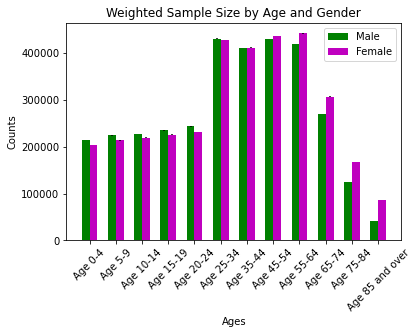

In [20]:
# Plotting
fig = plt.figure()
ax = fig.add_subplot(111)
ind = np.arange(len(ages))
# Offsetting the axis to plot side by side
ax.bar((ind - .15),m[p], width=.3,color='g',yerr=mout['Male MOE'])
ax.bar(ind + .15,f[p], width=.3,color='m', yerr=fout['Female MOE'])
ax.set_xticks(np.arange(len(ind)))
ax.set_xlabel('Ages')
ax.set_ylabel('Counts')
plt.xticks(ind,ages,rotation=45)
ax.legend(['Male','Female'])
ax.set_title('Weighted Sample Size by Age and Gender')
ax.plot()

# Race

### Indiana Weighted Sample Size by Age and Race

In [21]:
# Grouping by age group and race
age_dist = pd.DataFrame(Idata.groupby(['AgeRange','RAC1P']).sum())

In [22]:
RAout = moe_st_error(age_dist[p],age_dist[w]).reset_index()
RAout[' '] = (RAout[' '])
# Will no longer automatically output the moe standard error metrics, remove semicolon below
RAout.style.set_caption('Total Indiana Sample Size by Race and Age');

In [23]:
# Blank represents the weighted output
RA = pd.pivot_table(RAout[['AgeRange','RAC1P',' ']],
                    index = 'AgeRange',columns = 'RAC1P')

In [24]:
# Calculate proportions
RA.apply(lambda x: x / RA.sum(axis=1)
        ).style.set_caption('Proportions of Indiana Sample Size by Race and Age');

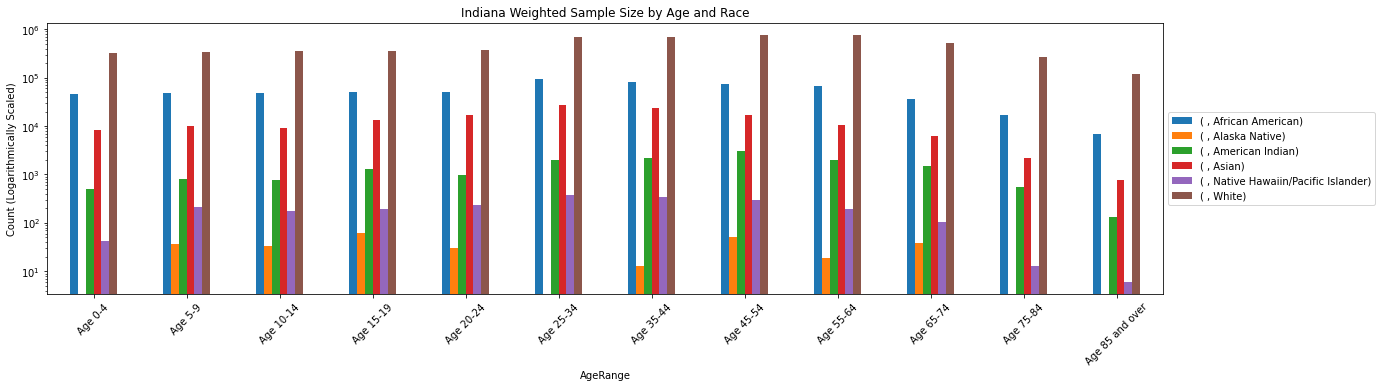

In [25]:
# Note the y is scaled logarithmically to better demonstrate differences
RA.plot(kind='bar',logy=True,ylabel='Count (Logarithmically Scaled)'
        ,figsize=(20,5), title='Indiana Weighted Sample Size by Age and Race',rot=45)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

### Indiana Weighted Sample Size by Gender and Race

In [26]:
# Group by sex and race
age_dist = pd.DataFrame(Idata.groupby(['SEX','RAC1P']).sum())

In [27]:
# MOE standard error confidence interval
gout = moe_st_error(age_dist[p],age_dist[w]).reset_index()

In [28]:
# Pivoting on race and gender
G = pd.pivot_table(gout[['SEX','RAC1P',' ']],
                   index = 'RAC1P',columns = 'SEX')
# Calculate proportions
G.apply(lambda x: x / G.sum(axis=1)).style.set_caption(
    'Total Indiana Sample Size by Race and Gender'); # remove semicolon to output

<AxesSubplot:title={'center':'Indiana Weighted Sample Size by Gender and Race'}, xlabel='RAC1P', ylabel='Count (Logarithmically Scaled)'>

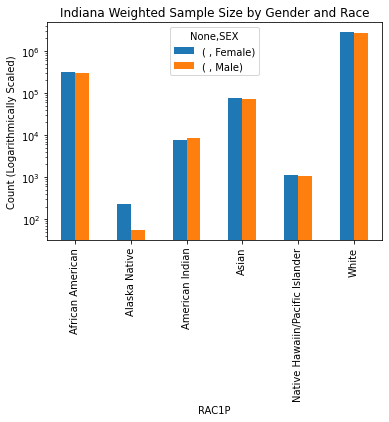

In [29]:
# Logarithmically scaled y axis
G.plot(kind='bar',logy=True, ylabel='Count (Logarithmically Scaled)'
       , title='Indiana Weighted Sample Size by Gender and Race',rot=90)

# Poverty

### Poverty by Age

In [30]:
# Grouping by age and poverty status
age_dist = pd.DataFrame(Idata.groupby(['AgeRange','pov_bool']).sum())

In [31]:
# MOE standard error confidence interval
Pout = moe_st_error(age_dist[p],age_dist[w]).reset_index()
Pout[' '] = (Pout[' '])

In [32]:
# Pivoting on age and poverty status
P = pd.pivot_table(Pout[['AgeRange','pov_bool',' ']],
                   index = 'AgeRange',columns = 'pov_bool')
# Calculate proportions
Pprop = P.apply(lambda x: x / P.sum(axis=1))
# Remove semicolon below to output
Pprop.style.set_caption('Proportion of Impoverished by Age');

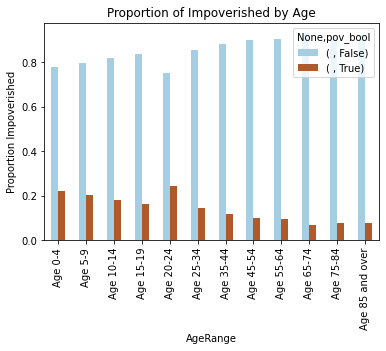

In [33]:
Pprop.plot(kind='bar', ylabel='Proportion Impoverished',
           title='Proportion of Impoverished by Age',rot=90,colormap='Paired');

### Poverty by Race

In [34]:
# Grouping by poverty status and race
age_dist = pd.DataFrame(Idata.groupby(['RAC1P','pov_bool']).sum())

In [35]:
#MOE standard error confidence interval
PRout = moe_st_error(age_dist[p],age_dist[w]).reset_index()
PRout[' '] = (PRout[' '])

In [36]:
# Pivoting on race and poverty status
PR = pd.pivot_table(PRout[['RAC1P','pov_bool',' ']],
                    index = 'RAC1P',columns = 'pov_bool')
# Calculate proportions
PRprop = PR.apply(lambda x: x / PR.sum(axis=1))
# Remove semicolon below to output
PRprop.style.set_caption('Proportion of Impoverished by Race');

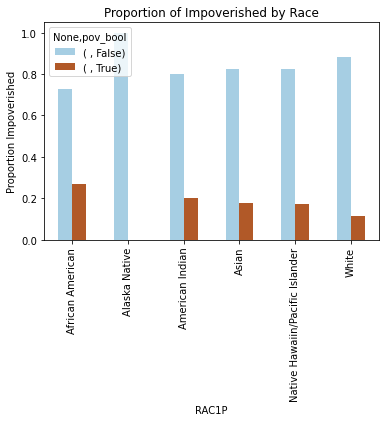

In [37]:
PRprop.plot(kind='bar', ylabel='Proportion Impoverished',
            title='Proportion of Impoverished by Race',rot=90,colormap='Paired');

### Poverty by PUMA

In [38]:
# Grouping by poverty and PUMA
age_dist = pd.DataFrame(Idata.groupby(['PUMACE10','pov_bool']).sum())

In [39]:
#MOE standard error confidence interval
PPout = moe_st_error(age_dist[p],age_dist[w]).reset_index()
PPout[' '] = (PPout[' '])

In [40]:
# Pivoting on PUMA and poverty status
PP = pd.pivot_table(PPout[['PUMACE10','pov_bool',' ']],
                    index = 'PUMACE10',columns = 'pov_bool')
# Calculate proportions
PPprop = PP.apply(lambda x: x / PP.sum(axis=1))
# Remove semicolon below to output
PPprop.style.set_caption('Proportion of Impoverished by PUMA}');

In [41]:
# Formatting for geopandas (removing multiindex/renaming cols)
geo_pov = PPprop.reset_index()
geo_pov.columns = geo_pov.columns.droplevel(1)
geo_pov.columns = ['PUMACE10', 'False','True']
geo_data['Pov'] = geo_pov['True']
geo_data;

Text(0.5, 1.0, 'Indiana Poverty Rates by PUMA')

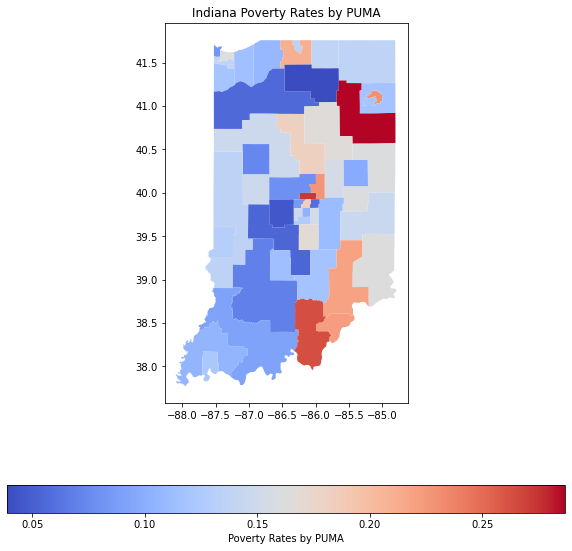

In [42]:
geo_data.plot(cmap='coolwarm',column='Pov',legend=True, figsize=(10,10),
              legend_kwds = {'label':'Poverty Rates by PUMA',
                             'orientation':'horizontal'}
             ).set_title('Indiana Poverty Rates by PUMA')

# Unemployment 

In [43]:
# Excluding the youth
youth_list = [18, 24, 34, 44, 54, 64, 74, 84, 99]
youth = ['Age 18-24', 'Age 25-34', 'Age 35-44', 'Age 45-54', 'Age 55-64', 'Age 65-74', 'Age 75-84', 'Age 85 and over']

In [44]:
Udata = Idata.copy()
# Recoding unemployment values
Udata['ESR'] = Udata['ESR'].apply(recode)

In [45]:
# Creating a column grouping people by age using above lists
Udata['AgeRange'] = pd.cut(Udata['AGEP'],youth_list,
                         labels=youth,include_lowest=True)
# Dropping missing values depending on age range and esr subsets
Udata = Udata.dropna(subset=['AgeRange', 'ESR'])
Udata['ESR'].value_counts()

Other    152535
Unemp      7703
Name: ESR, dtype: int64

### Unemployment by Age

In [46]:
# Grouping by age groups and unemployment status
age_dist = pd.DataFrame(Udata.groupby(['AgeRange','ESR']).sum())

In [47]:
# MOE standard error confidence interval
Uout = moe_st_error(age_dist[p],age_dist[w]).reset_index()
Uout[' '] = (Uout[' '])

In [48]:
# Pivot on age groups and unemployment status
U = pd.pivot_table(Uout[['AgeRange','ESR',' ']],
                   index = 'AgeRange',columns = 'ESR')
# Calculate proportions
Uprop = U.apply(lambda x: x / U.sum(axis=1))
# Remove semicolon below to output
Uprop.style.set_caption('Proportion of Unemployed by Age');

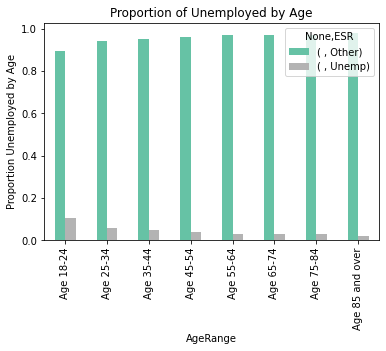

In [49]:
Uprop.plot(kind='bar', ylabel='Proportion Unemployed by Age',
           title='Proportion of Unemployed by Age',rot=90,colormap='Set2');

### Unemployment by Race

In [50]:
# Grouping by age groups and unemployment status
age_dist = pd.DataFrame(Udata.groupby(['RAC1P','ESR']).sum())

In [51]:
# MOE standard error confidence interval
URout = moe_st_error(age_dist[p],age_dist[w]).reset_index()
URout[' '] = (URout[' '])

In [52]:
# Pivot on age groups and unemployment status
UR = pd.pivot_table(URout[['RAC1P','ESR',' ']],
                   index = 'RAC1P',columns = 'ESR')
# Calculate proportions
URprop = UR.apply(lambda x: x / UR.sum(axis=1))
# Remove semicolon below to output
URprop.style.set_caption('Proportion of Unemployed by Race');

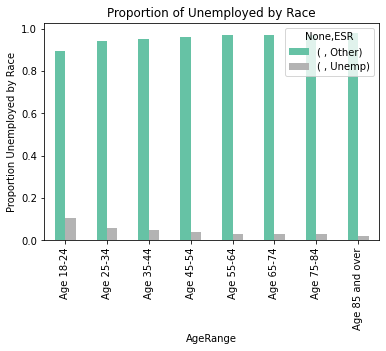

In [53]:
Uprop.plot(kind='bar', ylabel='Proportion Unemployed by Race',
           title='Proportion of Unemployed by Race',rot=90,colormap='Set2');

### Unemployment by PUMA

In [54]:
# Grouping by poverty and PUMA
age_dist = pd.DataFrame(Udata.groupby(['PUMACE10','ESR']).sum())

In [55]:
#MOE standard error confidence interval
PUout = moe_st_error(age_dist[p],age_dist[w]).reset_index()
PUout[' '] = (PUout[' '])

In [56]:
# Pivoting on PUMA and poverty status
PU = pd.pivot_table(PUout[['PUMACE10','ESR',' ']],
                    index = 'PUMACE10',columns = 'ESR')
# Calculate proportions
PUout = PU.apply(lambda x: x / PU.sum(axis=1))
# Remove semicolon below to output
PUout.style.set_caption('Proportion of Impoverished by PUMA}');

In [57]:
# Formatting for geopandas (removing multiindex/renaming cols)
geo_pov = PUout.reset_index()
geo_pov.columns = geo_pov.columns.droplevel(1)
geo_pov.columns = ['PUMACE10', 'False','True']
geo_data['Unemp'] = geo_pov['True']
# geo_data;

Text(0.5, 1.0, 'Indiana Unemployment Rates by PUMA')

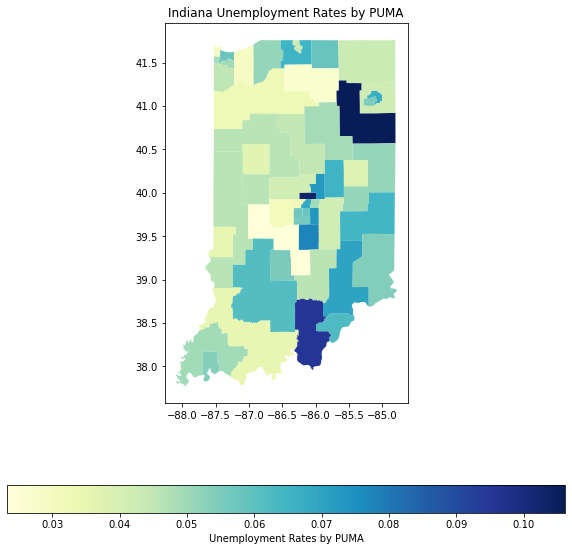

In [58]:
geo_data.plot(cmap = 'YlGnBu',column='Unemp',legend=True, figsize=(10,10),
              legend_kwds = {'label':'Unemployment Rates by PUMA',
                             'orientation':'horizontal'}
             ).set_title('Indiana Unemployment Rates by PUMA')

# Income

### Income by Age

### Income by Race

### Income by PUMA